# 1. Data Load

이제 제출을 해보겠습니다.

주어진 test데이터로 예측을 진행한 다음 sample_submission.csv에 예측한 값을 넣어보겠습니다.

앞서 train 셋에서 했던 동일한 전처리 과정을 거치되, data leakage가 발생하지 않도록 주의합니다.


In [24]:
import numpy as np
import pandas as pd
import os
import math
import random
from datetime import datetime

from scipy import stats #Analysis 
from scipy.stats import norm 
import pickle

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

In [25]:
path = "./Dataset/"

test = pd.read_csv(path+"train.csv")
test

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,country,introelapse,testelapse,surveyelapse,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,education,urban,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,1.0,USA,3,553,6,4.0,3.0,5.0,1.0,3.0,5.0,5.0,3.0,5.0,3.0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,2.0,1,3.0,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,1.0,4.0,5.0,3.0,1.0,2.0,4.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,5.0,USA,5,85,120,4.0,2.0,3.0,5.0,3.0,2.0,5.0,1.0,2.0,2.0,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,4.0,2,2.0,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,2.0,5.0,5.0,5.0,1.0,3.0,5.0,3.0,5.0,2.0,2.0,1.0,2.0,4.0,2.0,5.0,NLD,9,108,100,1.0,2.0,3.0,1.0,5.0,5.0,3.0,4.0,5.0,2.0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,2.0,1,1.0,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,5.0,2.0,2.0,4.0,4.0,2.0,4.0,5.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0,USA,2,121,139,3.0,3.0,3.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,1,1.0,3,1.0,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,4.0,3.0,5.0,5.0,2.0,4.0,1.0,4.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0,ITA,3,640,216,3.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,2.0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1.0,2,2.0,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,4.0,3.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0,USA,12,103,161,2.0,2.0,4.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0,1,1,1,1,1,0,0,0,0,1,0,1,1,1,1,1,2.0,2,2.0,1.0,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0
14996,14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,1.0,4.0,4.0,4.0,2.0,5.0,5.0,4.0,1.0,5.0,3.0,4.0,4.0,5.0,4.0,5.0,USA,31,106,179,3.0,2.0,4.0,5.0,4.0,3.0,4.0,1.0,2.0,2.0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,4.0,1,2.0,2.0,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1
14997,14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0,5.0,3.0,4.0,USA,17,103,168,1.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,1.0,1.0,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,1,2.0,2,2.0,1.0,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1
14998,14998,5.0,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,3.0,5.0,4.0,4.0,1.0,5.0,4.0,5.0,5.0,2.0,5.0,3.0,5.0,3.0,3.0,5.0,USA,14,68,109,1.0,1.0,3.0,5.0,4.0,5.0,5.0,4.0,2.0,1.0,1,1,1,1,1,0,0,1,0,1,0,1,1,1,1,1,3.0,2,2.0,1.0,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0


<AxesSubplot:>

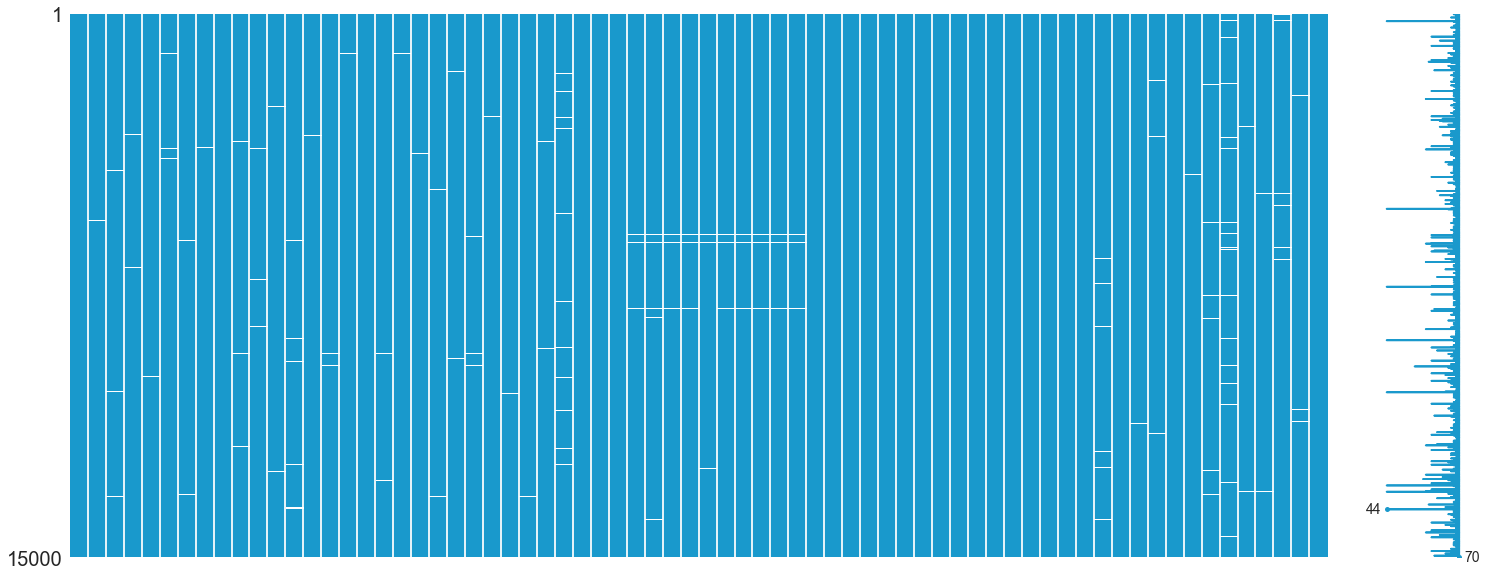

In [26]:
msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

# 2. Preprocessing 

In [27]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 

# Feature drop : 'index'
processed_data = test.drop(['index', 'country'], axis=1).copy()

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# Ranging and Ordinary encoding: 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)
oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))

# Handling outlier and iterative imputation : 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize']] = transformer.fit_transform(processed_data[['familysize']])
processed_data['familysize'] = processed_data['familysize'].astype(int)
print(processed_data['familysize'].describe())

count    15000.000000
mean         2.272667
std          0.841091
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:>

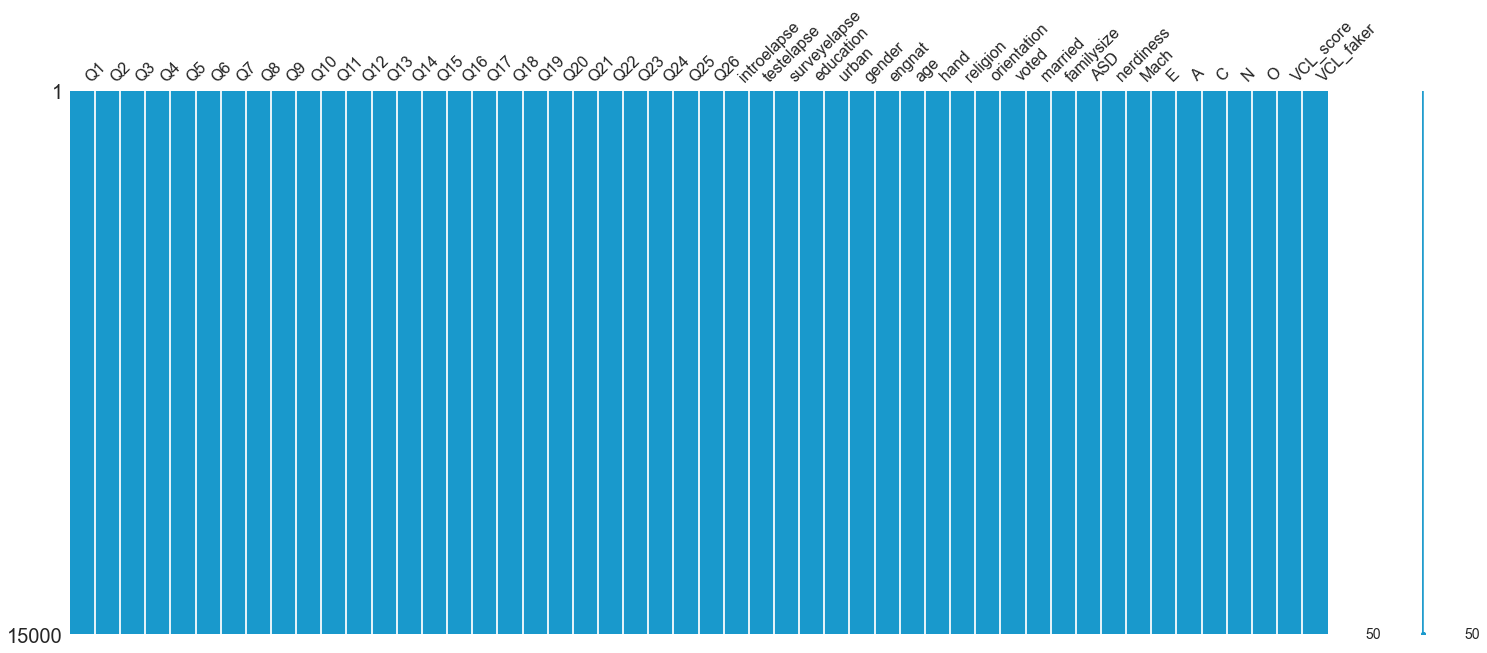

In [28]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

from sklearn.impute import SimpleImputer
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]
for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])

processed_data = score_mach(processed_data)
processed_data = score_tipi(processed_data)
processed_data = score_vcl(processed_data)

msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [29]:
processed_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness,Mach,E,A,C,N,O,VCL_score,VCL_faker
0,1.0,5.0,1.0,1.0,1.0,4.0,1.0,5.0,5.0,3.0,1.0,5.0,5.0,1.0,5.0,1.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,1.0,1.386294,6.317165,1.945910,2.0,1,3.0,1.0,1.0,2.0,12.0,4.0,2.0,1.0,4,2.0,1,3.05,3.5,5.0,5.0,6.0,4.0,8.0,0.0
1,4.0,4.0,2.0,2.0,4.0,5.0,2.0,4.0,3.0,3.0,5.0,4.0,5.0,3.0,1.0,4.0,2.0,1.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,5.0,1.791759,4.454347,4.795791,4.0,2,2.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,4,2.0,1,3.10,5.0,5.5,5.0,2.5,4.5,11.0,0.0
2,4.0,5.0,1.0,2.0,3.0,5.0,1.0,5.0,2.0,2.0,4.0,5.0,5.0,1.0,1.0,3.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,4.0,2.0,5.0,2.302585,4.691348,4.615121,2.0,1,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,4,2.0,1,3.00,2.0,4.5,3.5,6.0,5.5,11.0,0.0
3,4.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,4.0,2.0,1.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0,1.098612,4.804021,4.941642,1.0,3,1.0,1.0,0.0,2.0,1.0,1.0,2.0,1.0,2,2.0,1,2.95,4.0,4.5,3.5,3.5,5.0,9.0,0.0
4,4.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,4.0,3.0,1.0,5.0,4.0,2.0,5.0,4.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0,1.386294,6.463029,5.379897,1.0,2,2.0,2.0,0.0,2.0,12.0,1.0,2.0,1.0,1,2.0,0,2.95,3.5,4.0,4.0,3.5,5.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,2.0,3.0,3.0,4.0,2.0,4.0,3.0,2.0,5.0,4.0,4.0,3.0,4.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0,2.564949,4.644391,5.087596,2.0,2,2.0,1.0,0.0,1.0,1.0,3.0,2.0,1.0,3,2.0,0,3.15,2.5,4.5,4.5,4.0,4.0,10.0,1.0
14996,5.0,4.0,1.0,2.0,4.0,5.0,1.0,4.0,2.0,1.0,5.0,4.0,4.0,2.0,2.0,1.0,1.0,2.0,1.0,5.0,3.0,4.0,4.0,5.0,4.0,5.0,3.465736,4.672829,5.192957,4.0,1,2.0,2.0,3.0,1.0,3.0,1.0,1.0,2.0,3,2.0,1,2.80,4.0,5.0,5.5,2.5,5.0,8.0,0.0
14997,4.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,2.0,1.0,2.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,4.0,5.0,5.0,2.0,5.0,5.0,3.0,4.0,2.890372,4.644391,5.129899,2.0,2,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3,1.0,1,3.00,2.0,4.0,3.5,2.0,4.0,9.0,0.0
14998,5.0,5.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,3.0,5.0,4.0,2.0,1.0,1.0,2.0,1.0,5.0,2.0,5.0,3.0,5.0,3.0,3.0,5.0,2.708050,4.234107,4.700480,3.0,2,2.0,1.0,1.0,1.0,12.0,4.0,2.0,2.0,2,1.0,0,2.65,2.0,6.0,3.5,2.5,5.5,11.0,1.0


# 3. Data Split

In [30]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True,
    stratify=input_data_y,
)

test_X = test_X.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [31]:
# For DL data
# Normalize with z-score
test_X_nn = test_X.copy()
for col in test_X_nn.columns : 
    test_X_nn[col] = (test_X_nn[col] - test_X_nn[col].mean()) / test_X_nn[col].std()
test_X_nn

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,Mach,E,A,C,N,O,VCL_score,VCL_faker
0,-0.896724,0.801096,0.228388,-0.994172,0.946345,1.117918,-0.775290,0.842229,-0.970304,-0.843663,1.352770,0.975547,0.210418,2.402824,1.291775,-1.111516,0.837602,-0.821929,-0.882614,-0.618351,0.651627,0.427769,0.845461,0.765980,0.608831,0.808288,0.028183,-0.034870,0.961022,0.747262,-1.589113,0.524911,1.334969,0.051571,-0.391975,-0.624600,-0.718845,0.772268,-0.383741,-0.312016,0.260267,0.924975,0.542136,-0.279831,-0.777520,-0.922064,-0.458925,1.410370,-0.546119
1,0.926638,-0.882934,0.228388,-0.994172,-1.596721,-0.575507,-0.775290,0.842229,-0.004136,2.065886,1.352770,0.173292,-0.554475,0.661182,-1.340566,1.038496,-0.901576,-0.821929,-0.882614,1.110180,-1.219055,-1.045014,0.845461,0.765980,-0.839878,0.808288,-0.991687,0.102838,-0.016857,0.747262,1.140540,0.524911,-0.751044,0.051571,-0.391975,2.306959,-0.718845,-1.303093,-0.383741,-1.490916,0.260267,-0.337647,2.547408,0.928241,1.952636,1.042088,0.196250,-0.809520,-0.546119
2,0.014957,0.801096,0.228388,-0.994172,-0.749033,-0.575507,-0.775290,0.842229,0.811336,1.096036,-1.190041,0.975547,-1.319369,-1.080460,1.291775,1.755166,1.707190,-0.059623,1.055189,-0.618351,-1.219055,-1.045014,-2.114878,0.765980,0.608831,-1.192107,0.178960,0.278032,-0.016857,-0.343858,1.140540,-1.294965,1.334969,0.051571,-0.391975,-0.038288,-0.718845,-1.303093,-0.383741,-1.490916,0.260267,0.924975,0.040818,-0.279831,-0.777520,0.060012,-1.769277,-1.253497,-0.546119
3,-2.720087,-2.566963,0.013544,2.307396,-0.022984,-2.268932,3.010278,0.842229,2.592975,1.096036,1.352770,-2.233473,0.975312,0.661182,-1.340566,1.755166,-0.901576,1.464990,-1.528549,-2.346882,-1.219055,1.900553,-2.114878,0.765980,-1.564232,-3.192501,-0.360674,0.313254,0.460832,-0.343858,1.140540,0.524911,-0.751044,3.360935,-0.391975,0.841180,-0.718845,0.772268,-0.383741,-0.312016,0.260267,-0.006995,0.011164,0.017128,0.001677,0.004089,-0.001170,-1.253497,-0.546119
4,0.926638,0.801096,0.228388,-0.994172,0.946345,0.271206,-0.775290,0.063486,-0.970304,-0.843663,-0.554338,0.975547,0.210418,-1.080460,0.633690,-1.111516,-0.031987,-0.059623,-0.236680,0.245915,0.028067,-0.308622,-0.634709,0.765980,1.333185,-0.191909,2.510908,1.629702,-0.526582,0.747262,-0.224287,0.524911,-0.751044,1.706253,-0.391975,-0.624600,-0.718845,0.772268,-0.383741,2.045785,0.260267,-0.355701,-0.460500,-0.279831,-0.231489,0.060012,-1.114101,0.966392,-0.546119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.896724,-0.040919,0.228388,1.482004,-1.596721,0.271206,0.171102,0.842229,-0.079484,-0.843663,0.081365,-0.628963,-0.554475,0.661182,0.633690,-0.394845,1.707190,0.702683,-0.236680,-1.482616,0.651627,-0.308622,0.845461,-0.337779,-0.839878,-0.191909,0.339013,0.370324,0.149648,-0.343858,1.140540,0.524911,1.334969,-0.775770,-0.391975,-0.038288,-0.718845,0.772268,-0.383741,0.866885,0.260267,0.071191,-0.460500,0.928241,0.314543,-0.922064,0.851426,0.078436,-0.546119
2996,-0.896724,0.801096,0.228388,-0.168780,0.098656,0.271206,-0.775290,0.842229,-0.970304,0.126186,0.081365,0.975547,0.975312,-0.209639,1.291775,-0.394845,-0.901576,-0.821929,0.409255,1.110180,1.275188,0.427769,0.845461,0.765980,-0.115524,-0.191909,-0.840910,2.165838,1.824636,-1.434978,-0.224287,0.524911,-0.751044,-0.775770,-0.391975,-0.038288,-0.013073,0.010861,-0.383741,0.866885,0.260267,0.711529,-0.961818,0.928241,1.952636,1.042088,1.506602,0.078436,-0.546119
2997,0.014957,0.801096,0.228388,-0.168780,-0.749033,-0.575507,1.117494,-0.715256,1.702156,0.126186,-1.190041,-0.628963,0.210418,-0.209639,-1.340566,-0.394845,-0.901576,-0.059623,1.055189,0.245915,-1.219055,-1.045014,-2.114878,-1.441537,-0.839878,-0.191909,-0.148165,-0.0

# 4. Model Load

In [17]:
from pycaret.classification import *

model_ml = load_model(path+'AUC90_blend_0812_16_14') # you should fill out this part
print(model_ml)

Transformation Pipeline and Model Successfully Loaded
Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['urban',
                                                            'education',
                                                            'gender', 'engnat',
                                                            'hand', 'religion',
                                                            'orientation',
                                                            'voted', 'married',
                                                            'ASD', 'Q1', 'Q2',
                                                            'Q3', 'Q4', 'Q5',
                                                            'Q6', 'Q7', 'Q8',
                                                            'Q9', 'Q10', 'Q11',
                                                            'Q12', 'Q13', 'Q14',
                                                            'Q15',

In [32]:
import torch
from torch import nn

# Layer dim 
n_input_dim = train_X.shape[1]
n_hidden1 = 294
n_hidden2 = 32
n_output_dim = 1

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1)
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2) # bias = True
        self.layer_out = nn.Linear(n_hidden2, n_output_dim) 
        
        self.leakyrelu = nn.LeakyReLU(0.05)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_nn = torch.load(path+"nn_76_0810_23_12.pt", map_location= device)
test_X_torch = torch.tensor(test_X_nn.to_numpy(), dtype=torch.float32, device=device)
print(model_nn)

BinaryClassification(
  (layer_1): Linear(in_features=49, out_features=294, bias=True)
  (layer_2): Linear(in_features=294, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.05)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(294, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [18]:
pred_ml = predict_model(model_ml, data=test_X, raw_score=True)

In [33]:
pred_nn_prob = model_nn(test_X_torch)
pred_nn_prob = torch.sigmoid(pred_nn_prob)
pred_nn = torch.round(pred_nn_prob)
pred_nn = [a.squeeze().tolist() for a in pred_nn]
pred_nn_prob = [a.squeeze().tolist() for a in pred_nn_prob]
pred_dl = pd.DataFrame([ x for x in zip(pred_nn, pred_nn_prob)])

In [19]:
pred_ml[['Label', 'Score_1.0']].head(20)

,Label,Score_1.0
0,0.0,0.1958
1,0.0,0.1297
2,1.0,0.8996
3,0.0,0.0275
4,0.0,0.3390
5,1.0,0.8835
6,1.0,0.8571
7,1.0,0.9299
8,1.0,0.8522
9,1.0,0.8516


In [34]:
pred_dl.head(20)

,0,1
0,1.0,7.265230e-01
1,0.0,2.826951e-01
2,1.0,9.885653e-01
3,0.0,7.998711e-07
4,1.0,9.810270e-01
5,1.0,9.997382e-01
6,1.0,8.995605e-01
7,1.0,9.999073e-01
8,1.0,8.634664e-01
9,1.0,9.796627e-01


# 5. Ensemble

find out ensemble ratio 

In [14]:
from sklearn.metrics import roc_auc_score, classification_report

In [37]:
#print("ML: " , roc_auc_score(test_y, pred_ml['Score_1.0']))
print("DL: " , roc_auc_score(test_y, pred_dl[1]))

DL:  0.8297475044726379


In [119]:
print(classification_report(test_y, pred_ml['Label'].astype(float)))
print(classification_report(test_y, pred_dl[0]))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1339
           1       0.95      0.97      0.96      1661

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1339
           1       0.78      0.80      0.79      1661

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



In [22]:
y_pred = (pred_ml['Score_1.0']*0.8 + pred_dl[1]*0.2) 
pred_ensem = pd.DataFrame(y_pred)
#pred_ensem[0] = pred_ensem[0].apply(lambda x : 1 if x >= 0.5 else 0)
pred_ensem.head(20)

,0
0,0.301945
1,0.160299
2,0.917393
3,0.022000
4,0.467405
5,0.906748
6,0.865592
7,0.943901
8,0.854453
9,0.877213


In [ ]:
print("ENSEMBLE: " , roc_auc_score(test_y, pred_ensem))
print(classification_report(test_y, pred_ensem))

# 5. Submission

이제 학습한 모델을 사용하여 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다

In [35]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(path + 'sample_submission.csv')
submission.head()

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


In [36]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['nerdiness'] = pred_dl[1]

# 데이터가 잘 들어갔는지 확인합니다.
submission

,index,nerdiness
0,0,7.265230e-01
1,1,2.826951e-01
2,2,9.885653e-01
3,3,7.998711e-07
4,4,9.810270e-01
...,...,...
35447,35447,NaN
35448,35448,NaN
35449,35449,NaN
35450,35450,NaN


In [148]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M_%S")
filename

'0810_23_24_29'

In [149]:
submission.to_csv(path+"{}.csv".format(filename), index=False)